# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import keras
import cv2
from keras.applications.vgg16 import VGG16

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('train.csv').readlines())
val_doc = np.random.permutation(open('val.csv').readlines())
batch_size = 30

In [6]:
print(train_doc)

['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n'
 'WIN_20180926_17_30_47_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180926_17_29_23_Pro_Stop_new;Stop_new;2\n'
 'WIN_20180926_17_12_26_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180926_17_29_01_Pro_Stop_new;Stop_new;2\n'
 'WIN_20180907_16_32_11_Pro_Stop Gesture_new;Stop Gesture_new;2\n'
 'WIN_20180926_17_06_01_Pro_Stop_new;Stop_new;2\n'
 'WIN_20180907_16_52_18_Pro_Stop Gesture_new;Stop Gesture_new;2\n'
 'WIN_20180907_16_39_19_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n'
 'WIN_20180925_17_19_16_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180907_16_19_10_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n'
 'WIN_20180926_16_56_46_Pro

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
len(train_doc)

663

In [8]:
# Parameters initialization
rows = 120   # X dimension of the image
cols = 120   # Y dimesnion of the image
total_frames = 30  # lenght of the video frames
channel = 3 # color image (RGB) with channel 3

In [9]:
# Initializing all the batch image data and labels
def batch_data_init(batch_size):
    batch_data = np.zeros((batch_size, total_frames, rows, cols, channel)) 
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    return batch_data, batch_labels

In [10]:
def get_rand_affine():
    dx, dy = np.random.randint(-1.7, 1.8, 2)
    RA = np.float32([[1, 0, dx], [0, 1, dy]])
    return RA

In [11]:
def create_batch_images(source_path, folder_list, batch_num, batch_size, t,validation):
    batch_data,batch_labels = batch_data_init(batch_size) 
    # Augumented batch data with affine transformation
    batch_data_aug, batch_labels_aug = batch_data_init(batch_size)
    # Augmented batch data with horizontal flip
    batch_data_flip,batch_labels_flip = batch_data_init(batch_size)
    # list of image index/numbers in a particular video frame
    img_idx = [x for x in range(0, total_frames)] 

    for folder in range(batch_size):
        # read all the images in the folder
        imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])) 
        # Generate a random affine
        rand_affine_data = get_rand_affine()
        
        #  Iterate over the frames/images of a folder to read them in
        for idx, item in enumerate(img_idx): 
            # image = imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            image = cv2.imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Cropping non symmetric frames
            if image.shape[0] != image.shape[1]:
                image=image[0:120,20:140]
            
            #crop the images and resize them.  
            resized = cv2.resize(image, (rows,cols), interpolation = cv2.INTER_AREA)
            
            #Normal data
            batch_data[folder,idx] = (resized)
            
            # Data with affine transformation
            batch_data_aug[folder,idx] = (cv2.warpAffine(resized, rand_affine_data, (resized.shape[0], resized.shape[1])))
            
            # Data with horizontal flip
            batch_data_flip[folder,idx]= np.flip(resized,1)

        batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        batch_labels_aug[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
        # Labeling data with horizobtal flip
        ## right swipe becomes left swipe and viceversa
        if int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==0:
            batch_labels_flip[folder, 1] = 1
        elif int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==1:
            batch_labels_flip[folder, 0] = 1        
        else:
            batch_labels_flip[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
                  
    
    batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)
    batch_data_final = np.append(batch_data_final, batch_data_flip, axis = 0)

    batch_labels_final = np.append(batch_labels, batch_labels_aug, axis = 0) 
    batch_labels_final = np.append(batch_labels_final, batch_labels_flip, axis = 0)
    
    if validation:
        batch_data_final=batch_data
        batch_labels_final= batch_labels
        
    return batch_data_final,batch_labels_final

In [12]:
def generator(source_path, folder_list, batch_size, validation=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = 2 # len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # you yield the batch_data and the batch_labels, remember what does yield do
            yield create_batch_images(source_path, folder_list, batch, batch_size, t, validation)
            
        
        # Code for the remaining data points which are left after full batches
#         rem = len(t) % batch_size
#         if (rem>0):
#             batch_size = rem
#             yield create_batch_images(source_path, folder_list, batch, batch_size, t, validation)
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield create_batch_images(source_path, folder_list, batch, batch_size, t,validation)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = './train'
val_path = './val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

#write your model here
#initialising filters and dense 
filters = [8,16,32,64]
dense = [256, 128, 5]

# model
model = Sequential()

input_shape = (total_frames,rows,cols,channel)
num_classes = 5 # No of different output classes

# a keras convolutional layer is called Conv2D
#help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer
model.add(Conv3D(filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

# second conv layer
model.add(Conv3D(filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# third conv layer
model.add(Conv3D(filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# fourth conv layer
model.add(Conv3D(filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_4 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 60, 60, 16)   

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [17]:
optimiser = keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_4 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 60, 60, 16)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)


In [19]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)


# LR 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, reduce_lr]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [26]:
# Experiment 1
batch_size = 10
num_epochs = 20
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - 44s 661ms/step - loss: 1.6069 - categorical_accuracy: 0.2206 - val_loss: 1.6048 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_init_2020-08-1619_50_49.095264/model-00001-1.60691-0.22056-1.60483-0.22000.h5


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1043: RuntimeWarning: Reduce LR on plateau conditioned on metric `validation_loss` which is not available. Available metrics are: val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/20
67/67 [==============================] - 45s 670ms/step - loss: 1.5419 - categorical_accuracy: 0.2703 - val_loss: 1.6194 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_init_2020-08-1619_50_49.095264/model-00002-1.54192-0.27032-1.61937-0.16000.h5
Epoch 3/20
67/67 [==============================] - 43s 634ms/step - loss: 1.5370 - categorical_accuracy: 0.2852 - val_loss: 1.5110 - val_categorical_accuracy: 0.3300

Epoch 00003: saving model to model_init_2020-08-1619_50_49.095264/model-00003-1.53701-0.28524-1.51096-0.33000.h5
Epoch 4/20
67/67 [==============================] - 42s 633ms/step - loss: 1.5667 - categorical_accuracy: 0.3234 - val_loss: 1.4458 - val_categorical_accuracy: 0.3800

Epoch 00004: saving model to model_init_2020-08-1619_50_49.095264/model-00004-1.56667-0.32338-1.44575-0.38000.h5
Epoch 5/20
67/67 [==============================] - 43s 648ms/step - loss: 1.4653 - categorical_accuracy: 0.3781 - val_loss: 1.5958 - val_categorical_accurac

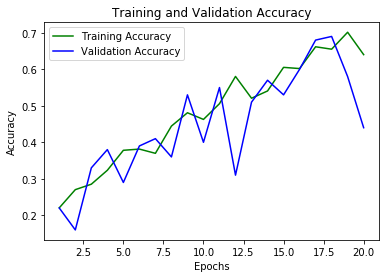

In [27]:
loss_train = history.history['categorical_accuracy']
loss_val = history.history['val_categorical_accuracy']
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
# Experiment 2
batch_size = 20
num_epochs = 20

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
34/34 [==============================] - 32s 938ms/step - loss: 0.8150 - categorical_accuracy: 0.7157 - val_loss: 0.9590 - val_categorical_accuracy: 0.5600

Epoch 00001: saving model to model_init_2020-08-1619_50_49.095264/model-00001-0.81502-0.71569-0.95905-0.56000.h5
Epoch 2/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1043: RuntimeWarning: Reduce LR on plateau conditioned on metric `validation_loss` which is not available. Available metrics are: val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


34/34 [==============================] - 22s 650ms/step - loss: 0.6345 - categorical_accuracy: 0.7712 - val_loss: 0.8017 - val_categorical_accuracy: 0.6400

Epoch 00002: saving model to model_init_2020-08-1619_50_49.095264/model-00002-0.63446-0.77124-0.80174-0.64000.h5
Epoch 3/20
34/34 [==============================] - 21s 611ms/step - loss: 0.6077 - categorical_accuracy: 0.7778 - val_loss: 0.8541 - val_categorical_accuracy: 0.6200

Epoch 00003: saving model to model_init_2020-08-1619_50_49.095264/model-00003-0.60774-0.77778-0.85412-0.62000.h5
Epoch 4/20
34/34 [==============================] - 22s 658ms/step - loss: 0.7858 - categorical_accuracy: 0.7157 - val_loss: 1.6625 - val_categorical_accuracy: 0.4800

Epoch 00004: saving model to model_init_2020-08-1619_50_49.095264/model-00004-0.78582-0.71569-1.66247-0.48000.h5
Epoch 5/20
34/34 [==============================] - 22s 654ms/step - loss: 0.9367 - categorical_accuracy: 0.6928 - val_loss: 1.2499 - val_categorical_accuracy: 0.5000



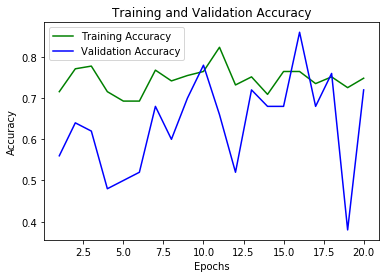

In [29]:
loss_train = history.history['categorical_accuracy']
loss_val = history.history['val_categorical_accuracy']
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# Experiment 3
batch_size = 30
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./val ; batch size = 30
Source path =  ./train ; batch size = 30
Epoch 1/30
23/23 [==============================] - 192s 8s/step - loss: 1.8373 - categorical_accuracy: 0.2308 - val_loss: 1.5674 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2020-08-1706_14_52.040840/model-00001-1.84705-0.23982-1.56741-0.30000.h5
Epoch 2/30
23/23 [==============================] - 12s 520ms/step - loss: 1.5277 - categorical_accuracy: 0.3478 - val_loss: 1.5692 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-08-1706_14_52.040840/model-00002-1.52768-0.34783-1.56921-0.25000.h5
Epoch 3/30
23/23 [==============================] - 17s 734ms/step - loss: 1.6598 - categorical_accuracy: 0.2415 - val_loss: 1.5082 - val_categorical_accuracy: 0.3250

Epoch 00003: saving model to model_init_2020-08-1706_14_52.040840/model-00003-1.65980-0.24155-1.50821-0.32500.h5
Epoch 4/30
23/23 [==============================] - 14s 629ms/step - loss: 1.54

23/23 [==============================] - 15s 655ms/step - loss: 1.1400 - categorical_accuracy: 0.4976 - val_loss: 1.2741 - val_categorical_accuracy: 0.4750

Epoch 00028: saving model to model_init_2020-08-1706_14_52.040840/model-00028-1.13997-0.49758-1.27406-0.47500.h5
Epoch 29/30
23/23 [==============================] - 15s 674ms/step - loss: 0.9916 - categorical_accuracy: 0.6184 - val_loss: 1.2081 - val_categorical_accuracy: 0.4750

Epoch 00029: saving model to model_init_2020-08-1706_14_52.040840/model-00029-0.99159-0.61836-1.20810-0.47500.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 30/30
23/23 [==============================] - 15s 672ms/step - loss: 1.0597 - categorical_accuracy: 0.5749 - val_loss: 1.2580 - val_categorical_accuracy: 0.4250

Epoch 00030: saving model to model_init_2020-08-1706_14_52.040840/model-00030-1.05968-0.57488-1.25801-0.42500.h5


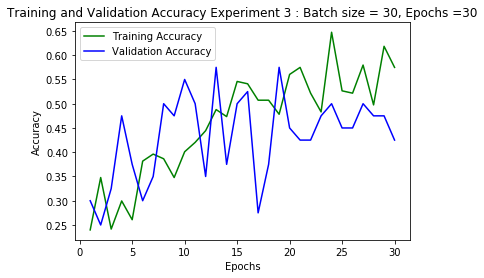

In [18]:
loss_train = history.history['categorical_accuracy']
loss_val = history.history['val_categorical_accuracy']
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy Experiment 3 : Batch size = 30, Epochs =30')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

With these experiments, we can conclude that Experiment 2 - batch size 20 and epochs 20,
17th epoch has best accuracy : train accuracy - 0.73, val accuracy -0.68.

Let us do Con2D +LSTM experiment

In [21]:
def getVGG16_GRU_Model(frames, img_width, img_height):
    model = VGG16(include_top = False, weights = 'imagenet', input_shape =  (img_width, img_height,3))
    x = Flatten()(model.output)
    
    features = Dense(64,activation='relu')(x)
    cnn_model = Model(inputs = model.input, outputs = features)
    cnn_rnn_model = Sequential()
    cnn_rnn_model.add(TimeDistributed(cnn_model, input_shape =  (frames,img_width, img_height,3)))
    cnn_rnn_model.add(GRU(64, return_sequences=True))
    cnn_rnn_model.add(GRU(16))
    cnn_rnn_model.add(Dropout(0.5))
    cnn_rnn_model.add(Dense(8,activation='relu'))
    cnn_rnn_model.add(Dense(5,activation='softmax'))
    return cnn_rnn_model

    

In [22]:
cnn_rnn_model = getVGG16_GRU_Model(total_frames, rows,cols)
cnn_rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 64)            15009664  
_________________________________________________________________
gru (GRU)                    (None, 30, 64)            24960     
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                3936      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 45        
Total params: 15,038,741
Trainable params: 15,038,741
Non-trainable params: 0
__________________________________________

In [23]:
optimiser = keras.optimizers.Adam(lr = 0.001) #write your optimizer
cnn_rnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_rnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 64)            15009664  
_________________________________________________________________
gru (GRU)                    (None, 30, 64)            24960     
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                3936      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 45        
Total params: 15,038,741
Trainable params: 15,038,741
Non-trainable params: 0
__________________________________________

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = 2 #int(num_train_sequences/batch_size)
else:
    steps_per_epoch = 2 #(num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = 2 #int(num_val_sequences/batch_size)
else:
    validation_steps = 2 #(num_val_sequences//batch_size) + 1

In [25]:
# Experiment 1
batch_size = 3
num_epochs = 2


In [26]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, validation=True)

In [ ]:
history = cnn_rnn_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
Source path =  ./train ; batch size = 3
Epoch 1/2
1/2 [==============>...............] - ETA: 0s - loss: 1.6229 - categorical_accuracy: 0.1111

In [ ]:
loss_train = history.history['categorical_accuracy']
loss_val = history.history['val_categorical_accuracy']
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()